# Training a NFF for zeolites

In [1]:
from NeuralForceField.train import *
from dbsetting import *
import numpy as np

# Get species, mostly silicate clusters

In [2]:
sps = Species.objects.filter(group__name='zeolite')

must_not_have = ['Al', 'C', 'N']
must_have = ['Si', 'O']

smiles_list = []
for sp in sps:
    if all([x in sp.smiles for x in must_have]) and not all([x in sp.smiles for x in must_not_have]):
#         print(sp.smiles)
        smiles_list.append(sp.smiles)

In [3]:
geoms_id = list(
    Geom.objects.filter(species__smiles__in=smiles_list,
                        parentjob__config__name= 'hessian_displacement_bp86_d3_svp_opt_orca'
    ).values_list("id", flat=True)
)

In [4]:
geoms = Geom.objects.filter(id__in=geoms_id)
# geoms = Geom.objects.filter(id__in=geoms_id[:2000])

In [5]:
values = get_xyz_force_energy_smiles(geoms, methodnames='dft_d3_gga_bp86')
xyz_data, force_data, energy_data, smiles_data = values

In [6]:
geoms.count()

23725

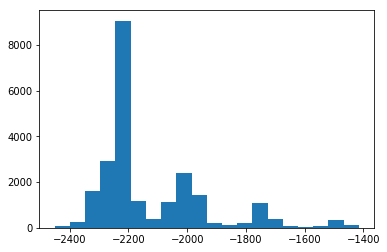

In [7]:
plt.hist(np.array(energy_data) * 27.4 * 23.05, bins=20)
plt.show()

# Initialize Training and Network Parameters 

In [8]:
# initialize parameters
par = dict()
par["git_commit"] = ""
par["model_type"] = "schnet"   # model type, the other type is schnet_harmonic_bond_prior
par["n_filters"] = 256         # the filter dimensions 
par["n_gaussians"] = 32        # number of gaussian basis
par["n_atom_basis"] = 256      # dimension of atomic embeddings 
par["optim"] = 1e-4            # learning rate
par["scheduler"] = True        # use scheduler to dynamiclly change the learning rate 
par["train_percentage"] = 0.8  # percentage of data used for training 
par["T"] = 4                   # number of convolutions 
par["batch_size"] = 10         # batch size
par["cutoff"] = 5.0            # convolution radius
par["max_epoch"] = 1000        # max number of epoches training
par["trainable_gauss"] = True  # make the Gaussian parameter trainable 
par["rho"] = 0.1               # energy loss ratio
par["eps"] = 1e-5

device = 2 # which GPU to use

# Import Graph Builder and build a graph data set for training 

In [9]:
from graphbuilder.graphbuilder import * 
from NeuralForceField.graphs import * 

graph_data = load_graph_data(xyz_data=xyz_data, energy_data=energy_data, smiles_data=smiles_data,
                             batch_size=par["batch_size"], cutoff=par["cutoff"], 
                             force_data=force_data, au_flag=True , )

Finished Batching 2327 Batches


In [15]:
with open('/home/dskoda/projects/zeoff/data/20190715_0833_10epochs_23725geoms.graph', 'wb') as f:
    pickle.dump(graph_data, f)

# Training

Initializes a model, splits train and test data randomly, start training for 10 epochs and look at validations

In [ ]:
model = ModelPrior(par=par, graph_data=graph_data, device=device, job_name="zeolite",
              train_flag= True, graph_batching=True, root='./log/')

setting up directoires for saving training files
epoch 0  U train: 42.938  force train 13.227
epoch 1  U train: 13.014  force train 6.136
epoch 2  U train: 10.289  force train 5.168
epoch 3  U train: 9.352  force train 4.530
epoch 4  U train: 8.416  force train 3.962
epoch 5  U train: 7.213  force train 3.429
epoch 6  U train: 6.532  force train 3.031
epoch 7  U train: 6.208  force train 2.739
epoch 8  U train: 5.301  force train 2.503
epoch 9  U train: 5.078  force train 2.318


OSError: [Errno 36] File name too long: './log/zeolite/O[Si](O)(O)O[Si](O)(O)O[Si](O)(O[Si](O)(O)O)O[Si]1(O)O[Si]2(O)O[Si](O)(O)O[Si]3(O[Si](O)(O)O[Si](O)(O1)O3)O2&O[Si](O)(O)O[Si](O)(O)O[Si](O[Si](O)(O)O)(O[Si](O)(O)O)O[Si](O)(O[Si](O)(O)O)O[Si](O)(O)O&O[Si](O)(O)O[Si](O)(O)O[Si]1(O)O[Si](O)(O)O[Si](O)(O)O[Si](O)(O)O[Si](O)(O[Si](O)(O)O)O[Si](O)(O)O1-7-15-12-29validation.jpg'

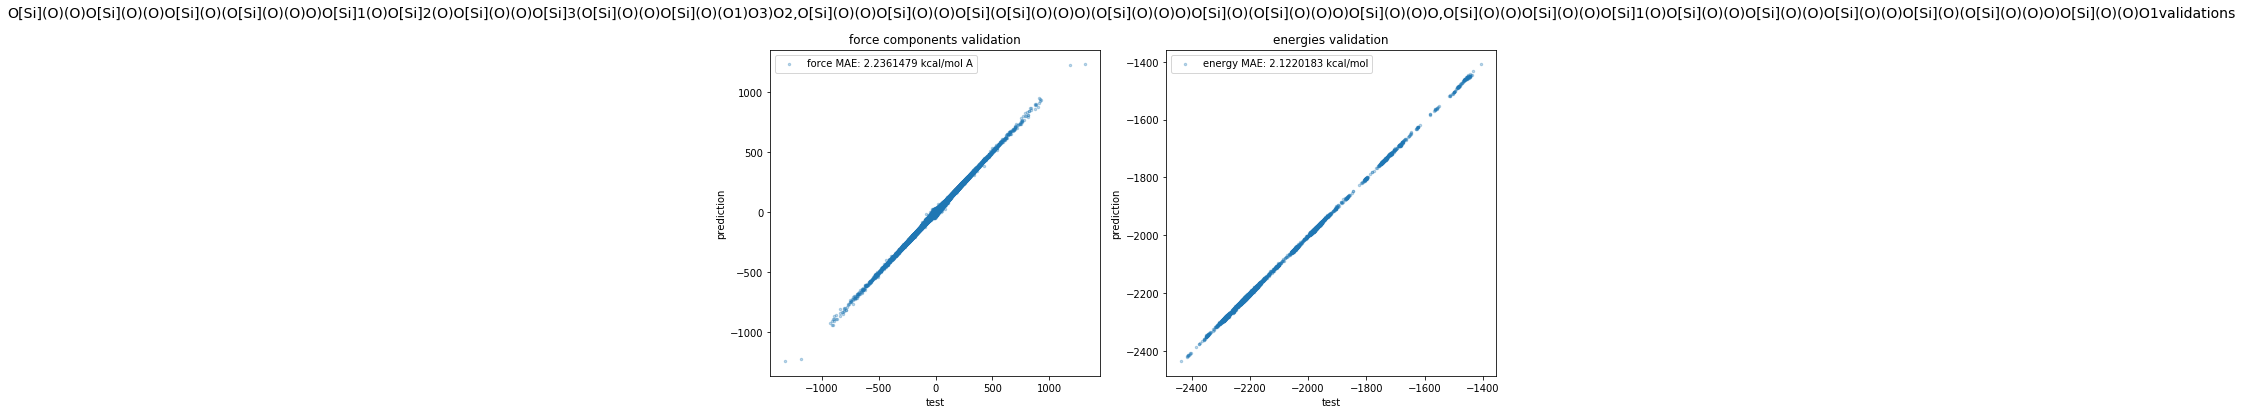

In [10]:
# Train for 10 epochs 
model.train(10)

OSError: [Errno 36] File name too long: './log/zeolite/O[Si](O)(O)O[Si](O)(O)O[Si](O)(O[Si](O)(O)O)O[Si]1(O)O[Si]2(O)O[Si](O)(O)O[Si]3(O[Si](O)(O)O[Si](O)(O1)O3)O2&O[Si](O)(O)O[Si](O)(O)O[Si](O[Si](O)(O)O)(O[Si](O)(O)O)O[Si](O)(O[Si](O)(O)O)O[Si](O)(O)O&O[Si](O)(O)O[Si](O)(O)O[Si]1(O)O[Si](O)(O)O[Si](O)(O)O[Si](O)(O)O[Si](O)(O[Si](O)(O)O)O[Si](O)(O)O1-7-15-12-29validation.jpg'

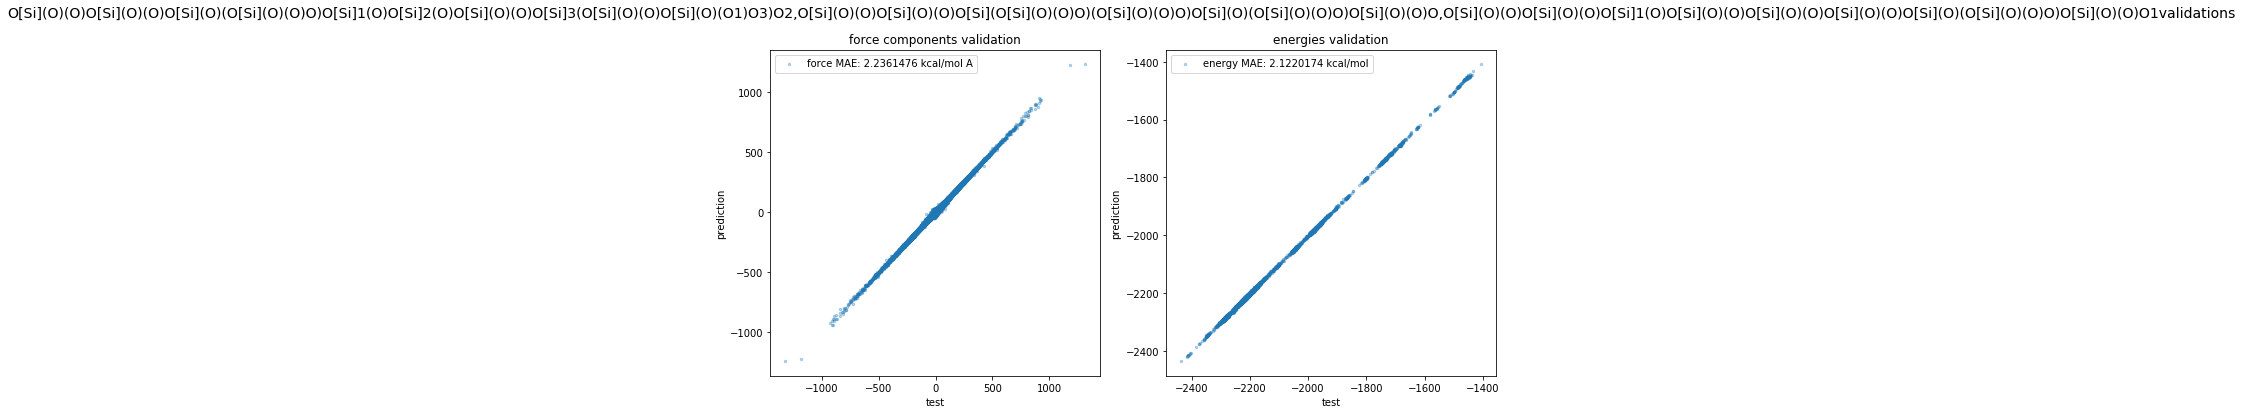

In [11]:
model.validate()

In [12]:
model.save_model('/home/dskoda/projects/zeoff/data/20190715_0833_10epochs_23725geoms.pt')